# Preprocessing

In [1]:
import numpy as np
import spacy
import gensim
import os
import re
from gensim.utils import simple_preprocess, lemmatize
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd
nlp = spacy.load("en_core_web_lg")

In [2]:
from bs4 import BeautifulSoup
from os import mkdir
import requests
#Dicitionary used to access full book text in HTML format
urls = {'foucault_madness_and_civ':'https://archive.org/stream/Michel_Foucault_Madness_And_Civilization/Michel%20Foucault%2C%20Richard%20Howard%20%28transl.%29%20-%20Madness%20and%20Civilization_%20A%20History%20of%20Insanity%20in%20the%20Age%20of%20Reason%20%282013%2C%20Vintage%29_djvu.txt',
        'foucault_discipline_and_punish': 'https://archive.org/stream/MichelFoucaultDisciplineAndPunish/Michel%20Foucault%20-%20Discipline%20and%20Punish_djvu.txt',
        'foucault_history_of_sexuality':'https://archive.org/stream/TheHistoryOfSexualityVol13/The-History-Of-Sexuality-Vol-1-3_djvu.txt',
        'chomsky_media_control': 'https://archive.org/stream/media_Noam_Chomsky-Media_Control/Noam_Chomsky-Media_Control_djvu.txt',
        'chomsky_american_power': 'https://archive.org/stream/AmericanPowerAndTheNewMandarins_201805/American%20Power%20And%20The%20New%20Mandarins_djvu.txt',
        'chomsky_manufacturing_consent': 'https://archive.org/stream/revhosatx14/%5BEdward_S._Herman%2C_Noam_Chomsky%5D_Manufacturing_Con%28b-ok.org%29_djvu.txt'}

In [3]:
def file_books(title, link):
    '''Create directories for book from title and link'''
    #Access HTML webpage on Internet Archive
    r = requests.get(link)
    data = r.text
    soup = BeautifulSoup(data)
    #Full text is in <pre> part of HTML doc
    book = soup.pre.string
    #Write book as text file, save file
    with open(f'./data/{title}.txt', 'w', encoding='utf-8') as book_file:
        book_file.write(book)
        #Make a folder for each book
        mkdir(f'./data/{title}_extracts')
def split_book(title, n_lines=100):
    '''Split a text file based on a number of lines, book title'''
    #Find file path based on title
    filepath = f'./data/{title}.txt'
    #Extract directory and filename from file path
    path, filename = os.path.split(filepath)
    #Change path to book's directory
    path += f'/{title}_extracts'
    # filename.split('.') would not work for filenames with more than one .
    basename, ext = os.path.splitext(filename)
    #open input file
    with open(filepath, 'r', encoding='utf-8') as book_file:
        try:
            #open the first output(extract) file
            extract_file = open(os.path.join(path, '{}_{}{}'.format(basename, 0, ext)), 'w', encoding='utf-8')
            #Loop over all lines of input file, number them
            for i, line in enumerate(book_file):
                #Close extract file and open a new one
                #When the line number % desired n_lines is 0
                if i % n_lines == 0:
                    extract_file.close()
                    #Open the next output file to write the next extract
                    extract_file = open(os.path.join(path, '{}_{}{}'.format(basename, i/100, ext)), 'w', encoding='utf-8')
                #write the line to extract file
                extract_file.write(line)
        finally:
            #close last output file
            extract_file.close()

In [4]:
if not os.path.isdir('./data'):  
    os.mkdir('./data')
for title, link in urls.items():
    if not os.path.isdir(f'./data/{title}_extracts'):
        file_books(title, link)
        split_book(title)

In [5]:
def tokenize(doc):
    '''Tokenizer with lemmatizer'''
    return [token.lemma_ for token in nlp(doc) if (token.is_stop == False) &
            (token.is_punct == False) & (token.is_space == False) &
            (token.is_upper == False) & (token.pos_ != 'PROPN')]
def gather_data(path_to_data):
    path = f'./data/{path_to_data}'
    data = {'extracts': [], 'author': []}
    #For file at the given path
    for file in os.listdir(path):
        #If the directory is not a folder
        if os.path.isdir(file) == False:
            #If the file type is .txt
            if file[-3:] == 'txt':
                #Open each text file at the path provided
                with open(os.path.join(path, file), encoding='utf-8') as t:
                    #Read and strip new line signal
                    text = t.read().replace('\n', ' ')
                    data['extracts'].append(str(text))
                    data['author'].append(path_to_data.split('_')[0])
    return data

In [6]:
tokenize('If you should ever leave me, Jack your LIFE would still go on believe me')      

['leave', 'believe']

In [24]:
extracts_dirs = [folder for folder in os.listdir('./data') if (os.path.isdir(f'./data/{folder}') == True)]

'american power extracts'

In [26]:
df_final = pd.DataFrame({'extracts': [], 'author': []})
for directory in extracts_dirs:
    extracts = gather_data(directory)
    df = pd.DataFrame(extracts, columns = extracts.keys())
    df_final = pd.concat([df_final, df], axis=0)
#     print(extracts['author'])
#     print(directory)
print(df_final.shape)
df_final = df_final.reset_index()

(1080, 2)


In [28]:
df_final.to_csv('./data/dataframe.csv', index=False)

In [29]:
import pickle
file = open(f'./data/dataframe.pkl', 'wb')
pickle.dump(df_final, file)

# Model

## Train/Test Split

In [11]:
import imblearn

ModuleNotFoundError: No module named 'imblearn'

In [12]:
from sklearn.model_selection import train_test_split
X = df_final['extracts']
y = df_final['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

## Randomized Search w/ Random Forest

In [43]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import Pipeline
counter = TfidfVectorizer(
#     max_df = .97,
#                           min_df = 5,
#                           stop_words='english',
# #                           ngram_range= (1,3),
                          tokenizer=tokenize)

rf = RandomForestClassifier()
nb = 
rusampler = RandomUnderSampler()
smote = SMOTE('all')

In [48]:
pipeline = Pipeline([('counter', counter),
                     ('sampler', rusampler),
                     ('rf', rf)])
parameters = {
    'counter__max_df': [i/100 for i in range(75, 100)],
    'counter__min_df': range(0, 10),
    'counter__ngram_range': [(1,2), (1, 3), (2,3), (3, 6), (2, 7)],
    'counter__analyzer': ['word', 'char', 'char_wb'],
    'rf__max_depth': range(5,20),
    'rf__min_samples_split': range(2, 10),
    'rf__min_samples_leaf': range(1,50)
}

rand_search = RandomizedSearchCV(pipeline, parameters, cv=2, n_iter=8, n_jobs=1, verbose=2)

In [49]:
best = rand_search.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] rf__min_samples_split=4, rf__min_samples_leaf=11, rf__max_depth=16, counter__ngram_range=(2, 7), counter__min_df=9, counter__max_df=0.76, counter__analyzer=word 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__min_samples_split=4, rf__min_samples_leaf=11, rf__max_depth=16, counter__ngram_range=(2, 7), counter__min_df=9, counter__max_df=0.76, counter__analyzer=word, total= 2.4min
[CV] rf__min_samples_split=4, rf__min_samples_leaf=11, rf__max_depth=16, counter__ngram_range=(2, 7), counter__min_df=9, counter__max_df=0.76, counter__analyzer=word 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV]  rf__min_samples_split=4, rf__min_samples_leaf=11, rf__max_depth=16, counter__ngram_range=(2, 7), counter__min_df=9, counter__max_df=0.76, counter__analyzer=word, total= 2.6min
[CV] rf__min_samples_split=2, rf__min_samples_leaf=23, rf__max_depth=9, counter__ngram_range=(1, 2), counter__min_df=4, counter__max_df=0.82, counter__analyzer=word 
[CV]  rf__min_samples_split=2, rf__min_samples_leaf=23, rf__max_depth=9, counter__ngram_range=(1, 2), counter__min_df=4, counter__max_df=0.82, counter__analyzer=word, total= 2.6min
[CV] rf__min_samples_split=2, rf__min_samples_leaf=23, rf__max_depth=9, counter__ngram_range=(1, 2), counter__min_df=4, counter__max_df=0.82, counter__analyzer=word 
[CV]  rf__min_samples_split=2, rf__min_samples_leaf=23, rf__max_depth=9, counter__ngram_range=(1, 2), counter__min_df=4, counter__max_df=0.82, counter__analyzer=word, total= 2.6min
[CV] rf__min_samples_split=6, rf__min_samples_leaf=36, rf__max_depth=5, counter__ngram_range=(1, 2), counter__min_df=8, coun

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 29.5min finished


In [50]:
best.best_estimator_.score(X_val, y_val)

0.9743589743589743

In [56]:
best.best_estimator_[0]

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.82, max_features=None,
                min_df=4, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x00000166C3F0F288>,
                use_idf=True, vocabulary=None)

In [ ]:
import pickle 
filename = 'rf_model.sav'
pickle.dump(best, open(filename, 'wb'))

## Nearest Neighbors Classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
counter = best.best_estimator_[0] #from previous randomized search

In [207]:
counts_train = counter.fit_transform(X_train).todense()
counts_val = counter.transform(X_val).todense()

In [58]:
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=1)
knn.fit(counts_train, y_train)

NameError: name 'KNeighborsClassifier' is not defined

In [212]:
from sklearn.metrics import accuracy_score
y_pred = knn.predict(counts_val)
accuracy_score(y_val, y_pred)

0.5493615696044846

In [16]:
from sklearn.metrics import roc_auc_score
y_pred = best.best_estimator_.predict(X_val)

In [ ]:
import pickle 
filename = 'knn_model.sav'
pickle.dump(best, open(filename, 'wb'))

# Word Embeddings with Spacy

In [83]:
def get_doc_vectors(words):
    # converts a list of words into their word vectors
    tokens = tokenize(words)
    string = ' '.join(tokens)
    return nlp(string).vector

In [84]:
get_doc_vectors('If you should ever leave me, your life should still go on believe me!')

array([ 0.03295   ,  0.38696995, -0.27896032,  0.01172933, -0.14194854,
       -0.003141  , -0.165784  , -0.01600266,  0.11609102,  2.9634    ,
       -0.24353667,  0.09561033,  0.05638926,  0.29460767, -0.27181664,
        0.06903766, -0.34141335,  0.8254733 , -0.25299898,  0.24724667,
        0.13279666,  0.010783  ,  0.135452  ,  0.10959434,  0.09863899,
        0.04335667,  0.04496   , -0.16768067,  0.15088034,  0.01015398,
       -0.13885666,  0.15474233, -0.25317332, -0.09746367,  0.14349133,
        0.16072391,  0.14422335, -0.10444767, -0.12391373,  0.00907667,
        0.02071233,  0.00457766,  0.02433067,  0.14915867,  0.16236967,
       -0.04752437, -0.19396   , -0.12991066,  0.12608325,  0.126854  ,
       -0.09501532, -0.11639333, -0.02847833, -0.17158334,  0.27571   ,
        0.02712333, -0.11324999, -0.28153667,  0.15989633,  0.05634667,
       -0.02932333, -0.16344   , -0.068507  , -0.15853073,  0.06580467,
        0.03637666, -0.21820533,  0.19327335,  0.03913667,  0.09

In [45]:
df_final.head()

,index,extracts,author
0,0,:| r?|| f • >0* rl; 1=/!= If j ' a?KJi...,chomsky
1,1,,chomsky
2,2,.: ^l|pp|!j£|!£K;£iS:x;£j!:B5inf!H:...,chomsky
3,3,there is no powerful outside force that can ca...,chomsky
4,4,"by Maruyama, in his analysis of the “theory an...",chomsky


In [60]:
from sklearn.decomposition import PCA
import pickle
pca = PCA(2)
word_vecs_2d = pca.fit_transform(get_doc_vectors(df_final['extracts']))

In [ ]:
word_vecs_train = get_doc_vectors(X_train)
word_vecs_val = get_doc_vectors(X_val)
word_vecs_test = get_doc_vectors(X_test)

In [65]:
#Pickle 2D word vectors for use in dash app
file = open(f'./models/word_vectors.pkl', 'wb')
pickle.dump(word_vecs_2d, file)

In [72]:
get_doc_vectors('hi')

[array([-2.9438e-01,  1.2145e+00, -6.9893e-01, -7.2192e-02, -9.7058e-02,
         1.7576e-01, -2.4219e-01, -2.2113e-01,  3.7196e-01, -1.4523e-02,
        -3.7705e-01, -2.0253e-01, -2.8155e-01,  1.6605e-02,  3.9833e-01,
        -1.2631e-01, -4.4380e-01,  2.2938e+00, -3.9182e-01,  2.7265e-02,
         1.5377e-01, -3.5372e-02, -3.1541e-01,  1.7574e-01,  6.0704e-01,
         5.2926e-02, -4.6530e-01,  2.5853e-01, -9.8812e-02,  1.1605e-02,
        -3.6801e-01, -3.0423e-02,  8.8122e-02, -9.3328e-02, -4.8047e-03,
        -3.4587e-01, -5.1317e-01, -6.8212e-02, -6.2714e-01,  1.7692e-01,
        -3.7108e-01, -8.6324e-01, -2.5097e-01,  4.9119e-01, -9.3501e-01,
        -7.0040e-02, -1.8575e-01,  3.6302e-01,  2.5413e-01, -2.8973e-01,
         9.8123e-02,  3.5030e-01, -2.9970e-01,  2.3193e-01, -1.4711e-01,
        -1.5028e-01,  1.9276e-02, -5.5462e-01,  9.6845e-02,  1.5598e-01,
        -2.1291e-01,  3.7283e-01, -2.6649e-01, -2.7698e-01, -2.4186e-01,
         1.0619e-01,  5.6559e-01, -1.0429e-02,  2.4

In [70]:
from sklearn.pipeline import make_pipeline
for k in range(5, 25, 5):
    pca = PCA(2)
    knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors = k, weights='distance', metric='euclidean')
    pipeline = make_pipeline(pca, knn)
    pipeline.fit(word_vecs_train, y_train)
    print(pipeline.score(word_vecs_test, y_test), pipeline.predict_proba(get_doc_vectors('')))
#     file = open(f'./models/model_k{k}.pkl', 'wb')
#     pickle.dump(pipeline, file)
#     file.close()

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [32]:
for k in range(7, 12):
    pca = PCA(2)
    knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors = k, weights='distance', metric='euclidean')
    pipeline = make_pipeline(pca, knn)
    pipeline.fit(word_vecs_train, y_train)
    print(pipeline.score(word_vecs_test, y_test))

0.9444444444444444
0.9444444444444444
0.9351851851851852
0.9444444444444444
0.9351851851851852


In [87]:
def display_results(text, k):
    file = open(f'./models/model_k{k}.pkl', 'rb')
    model = pickle.load(file)
    file.close()
    vector = get_doc_vectors(text)
    new_obs = vector
    pred = model.predict(new_obs)[0]
    return f'The author most likely to have written your sample, "{text}", is {pred}.'

display_results('Noam Chomsky was a great author', 5)

'The author most likely to have written your sample, "Noam Chomsky was a great author", is foucault.'

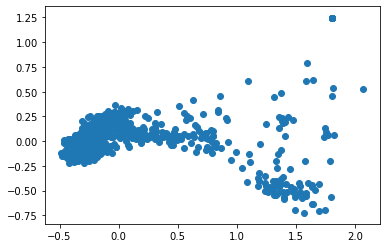

In [61]:
plt.scatter(x=word_vecs_2d[:, 0],y=word_vecs_2d[:,1])

Text(0.5, 1.0, '')

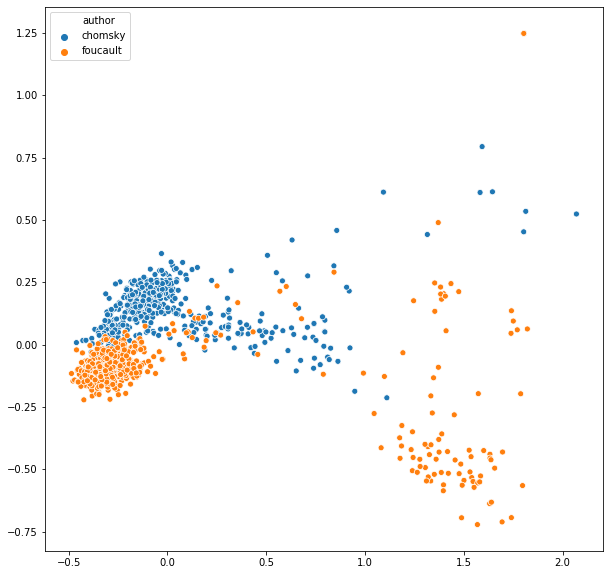

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.scatterplot(word_vecs_2d[:,0], word_vecs_2d[:,1], hue=df_final['author'])
plt.title('')

# Word Embeddings w/ Gensim

In [ ]:
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

In [137]:
def read_corpus(series, tokens_only=False):
    for i, doc in enumerate(series):
        tokens = gensim.utils.simple_preprocess(doc)
        print(tokens)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [149]:
next(read_corpus(df_final['extracts']))

['rl', 'if', 'kjii', 'jp', 'kwsg', 'ffc', 'fffjil', 'ri', 'hscif', 'piini', 'pqb', 'ffi', 'ipil', 'igij', 'ssbhlil', 'ps', 'im', 'iilb', 'ii', 'msjr', 'tashi', 'nst', 'liii', 'sf', 'ic', 'tta', 'ksp', 'mr', 'izlv', 'siirhki', 'hhh', 'fjfi', 'imimmiumnmum', 'mm', 'ar', 'kttaskni', 'ks', 'ssi', 'sr', 'ziubuss', 'fmhlll', 'fiiblii', 'hi', 'hr', 'hhi', 'rwm', 'tret', 'sks', 'nh', 'ii']


TaggedDocument(words=['rl', 'if', 'kjii', 'jp', 'kwsg', 'ffc', 'fffjil', 'ri', 'hscif', 'piini', 'pqb', 'ffi', 'ipil', 'igij', 'ssbhlil', 'ps', 'im', 'iilb', 'ii', 'msjr', 'tashi', 'nst', 'liii', 'sf', 'ic', 'tta', 'ksp', 'mr', 'izlv', 'siirhki', 'hhh', 'fjfi', 'imimmiumnmum', 'mm', 'ar', 'kttaskni', 'ks', 'ssi', 'sr', 'ziubuss', 'fmhlll', 'fiiblii', 'hi', 'hr', 'hhi', 'rwm', 'tret', 'sks', 'nh', 'ii'], tags=[0])